In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools as it

## the plan:
- Generate random graphs, with each node containing a tf constant (risk) and variable (allocated resources)
- run a simple optimization to allocate resources according to risk, where cost is risk\*resources for each node
- run more complex optimization where cost is (risk + lambda\*sum(neighbor_risk))\*resources. This will simulate a more realistic graph query with more useful output. Intuitively, you may want to allocate more resources to entities that are also associated with risky entities


In [2]:
# create new session if we need it
sess = tf.Session()

node 0 {'allocation': <tensorflow.python.ops.variables.Variable object at 0x114e50c10>, 'risk': <tf.Tensor 'Const_13:0' shape=() dtype=float32>} 0.56178
node 1 {'allocation': <tensorflow.python.ops.variables.Variable object at 0x114e50c50>, 'risk': <tf.Tensor 'Const_14:0' shape=() dtype=float32>} 0.225623
node 2 {'allocation': <tensorflow.python.ops.variables.Variable object at 0x114e45d50>, 'risk': <tf.Tensor 'Const_15:0' shape=() dtype=float32>} 0.938131
node 3 {'allocation': <tensorflow.python.ops.variables.Variable object at 0x11541cdd0>, 'risk': <tf.Tensor 'Const_16:0' shape=() dtype=float32>} 0.928703
node 4 {'allocation': <tensorflow.python.ops.variables.Variable object at 0x1154e5410>, 'risk': <tf.Tensor 'Const_17:0' shape=() dtype=float32>} 0.956527
...


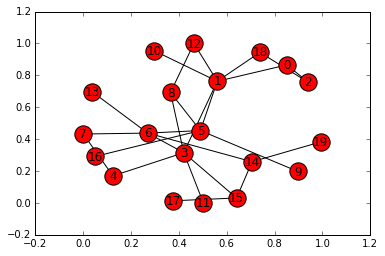

In [6]:
# generate a simple but nontrivial random graph
n = 20
dup_edge_p = 0.3

sess.run(tf.global_variables_initializer())
G_rand = nx.duplication_divergence_graph(n, dup_edge_p, 1)

# add tf risk constants and variables to each node
for node, data in G_rand.nodes_iter(data=True):
    data['risk'] = tf.constant(np.random.uniform(0,1))
    data['allocation'] = tf.Variable(tf.random_normal([1,1], stddev=0.35))
    
# show what we generated
for node, data in it.islice(G_rand.nodes_iter(data=True),5):
    print 'node',node, data, sess.run(data['risk'])
print '...'
    
nx.draw_networkx(G_rand,arrows=True)

In [15]:
# first query, just sum risk/allocation and l2 norm
def query1(G, alpha=tf.constant(0.0)):
    allocation_sumexp = tf.constant(0.0)
    risk_sum = tf.constant(0.0)
    for node, data in G.nodes_iter(data=True):
        allocation_sumexp += tf.exp(data['allocation'])
        risk_sum += data['risk']
    
    return_value = tf.constant(0.0)
    for i in nx.dfs_preorder_nodes(G, 0):
        node = G.node[i]
        softmax_allocation = tf.exp(node['allocation'])/allocation_sumexp
        normalized_risk = tf.exp(node['risk'])/risk_sum
        node['softmax_allocation'] = softmax_allocation
        return_value += return_value + (normalized_risk/softmax_allocation) + alpha*node['allocation']**2
#         return_value += return_value + tf.constant(2.0)*(tf.log(normalized_risk) - node['allocation'] 
#                                                          + tf.log(allocation_sumexp))
#         return_value += return_value - tf.constant(0.5)*(tf.log(normalized_risk)) \
#                                      - tf.constant(0.4)*(tf.log(softmax_allocation) - tf.log(allocation_sumexp))
    return return_value

(0, array([[ 1635980.25]], dtype=float32))
(10, array([[ 1127116.75]], dtype=float32))
(20, array([[ 1046113.]], dtype=float32))
(30, array([[ 1013782.]], dtype=float32))
(40, array([[ 998562.3125]], dtype=float32))
(50, array([[ 990425.5]], dtype=float32))
(60, array([[ 985623.3125]], dtype=float32))
(70, array([[ 982563.625]], dtype=float32))
(80, array([[ 980494.75]], dtype=float32))
(90, array([[ 979030.75]], dtype=float32))

node  0 risk 0.56178 allocation [[ 0.30732787]] softmax allocation [[ 0.25280681]]
node  1 risk 0.225623 allocation [[-0.065525]] softmax allocation [[ 0.17412488]]
node  2 risk 0.938131 allocation [[-4.24862432]] softmax allocation [[ 0.00265561]]
node  3 risk 0.928703 allocation [[-0.07127526]] softmax allocation [[ 0.17312647]]
node  4 risk 0.956527 allocation [[-0.37271255]] softmax allocation [[ 0.12807104]]
node  5 risk 0.755939 allocation [[-1.84304094]] softmax allocation [[ 0.02943713]]
node  6 risk 0.293408 allocation [[-1.33436024]] softmax allocati

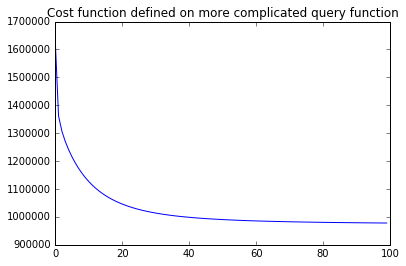

In [16]:
def test1():
    learning_rate = 1.0
    alpha = tf.constant(0.2)
    cost = query1(G_rand, alpha=alpha)
    optimizer = tf.train.AdagradOptimizer(learning_rate)
    train = optimizer.minimize(cost)
    #reinitialise everything
    sess.run(tf.global_variables_initializer())
    #Now optimize with this form
    train_steps=100
    cost_tracker = np.zeros([train_steps])
    for step in range(train_steps):
        sess.run(train)
        if step%10==0:
            print(step, sess.run(cost))
        cost_tracker[step] = sess.run(cost)
    plt.plot(cost_tracker)
    plt.title("Cost function defined on more complicated query function")
    
    print 
    for node, data in G_rand.nodes_iter(data=True):
        print 'node ',node, 'risk', sess.run(data['risk']),\
              'allocation', sess.run(data['allocation']),\
              'softmax allocation', sess.run(data['softmax_allocation'])
    
test1()